In [1]:
%gui osx
# %matplotlib inline an alternative except on retina macbooks
import random as rand
import pygame as pg

from genelife import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))     # sets input cells to use full window width

from os import environ
environ['SDL_VIDEO_WINDOW_POS'] = "%d,%d" % (1000,32)   # set position of pygame (SDL) video window (x,y) pixel coords, values work well on iMac

pygame 1.9.5.dev0
Hello from the pygame community. https://www.pygame.org/contribute.html


# Graphics notes

This notebook uses the pygame interface.

It pops up a pygame window (labeled "Gene Life"), which must be moved to the side to see the notebook. This window is not hardware acclerated on Mac - [see pg.display.Info()].

To stop the simulation mid-stream, you can OPTION click on the pygame window, click in the window. 

Simulations can be restarted using run() and the current timestep can be investigated graphically by calling run with updatesenabled = False. Initial state display with show0() and single stepping with step() are possible. 

The caption contains information about current state and mode.

Clicking on the window will give mouse position dependent information about local state.

Color is currently a 32 bit hash of the 64 bit gene value in colorfunction mode 0. There are 9 display modes accessible via left and right arrow keys:

    0 Randomly hashed colors based on gene value
    1 Functional coloring - differs according to selection model
    2 Overlay of non GoL rule cases in yellow
    3 Overlay of active states produced by a non GoL rule in yellow
    4 Activity plot scaled as activity/(activity+ymax) with interactive */ 2 for ymax
    5 Genealogies of N most populated genes : 1 pixel/ancestral change (ancestor at top)
    6 Genealogies of N most pop'd genes: with vertical time from start, colors as in mode 0
    7 Genealogies as in 6, but colors brightness rescaled by activities
    8 Glider detect: diff in packed 3-nbhoods with (dx,dy,dt), for (0,0,0) all 1-nbs with dt=-1 

To change resolution N: (only powers of 2 are allowed, typically 8,9,10 for N=256,512,1024)
* change `subgenelife.c` line 17 (`log2N`) and rebuild c lib [we utilize the efficiency gains of N fixed as power of two at compile time]

Quadrant modes (keys Q,q,alt-q) are available for evolving parameters (selection < 8).

Horizon mode (toggle with key r) couples with strictly GoL rules in upper (sky) half-plane (selection < 8). Idea is that teeming life in the sea (lower halfplane) may evolve to colonize the sky (upper halfplane).

# Parameter help

In [2]:
def parhelp():
    if selection < 8:
        print "Control bits (left to right):"
        print "____________________________"
        print "Green    ","0. selective birth for 3-live-nbs  ","1. selective birth for 2-live-nbs"
        print "Mid Blue ","2. canonical 0 position vs difft   ","3. bypass selection for 2-live-nbs"
        print "Teal blue","4. enforce birth for 3-live-nbs    ","5. enforce birth for 2-live-nbs"
        print "Red      ","6. 2nd neighbour genetic modulation","7. 1st neighbour genetic masking"
        print "Yellow   ","8. enforce GoL rule if non GoL rule","9. enforce GoL rule last change by non GoL rule */"
        print "Green    ","10-13. allow 2-nb birth only for active subset of 4 canonical configs"
        print "Blue     ","14. Survival for 3-live-nbs        ","15. Survival for 2-live-nbs"
        print "Green    ","16. Gene overwrite for 3-live-nbs  ","17. Gene overwrite for 2-live-nbs"
    elif selection == 8:
        print "Control bits for masks to enable gene encoded LUTs (left to right):"
        print "___________________________________________________________________"
        print "Masks for LUT rules for sums 2-6 for survival /left half) and birth (right half)"
        print "blue      ","survival for sum=1-8 separate buttons for the 8 non-zero sums"
        print "green     ","birth    for sum=1-8 separate buttons for the 8 non-zero sums"      
    elif selection == 9:
        print "Control bits for masks to enable gene encoded LUTs (left to right):"
        print "___________________________________________________________________"
        print "A finer division of LUT rules for sums 2-6 for survival /left half) and birth (right half)"
        print "red      ","sum=2,6 separate buttons for the  4 canonical rotations"
        print "green    ","sum=3,5 separate buttons for the  7 canonical rotations"
        print "blue     ","sum=4   separate buttons for the 10 canonical rotations"
    print ""
    print "Other controls:"
    print "_______________"
    print "middle mouse","stop simulation [data is retained for possible run() for run/analysis with updatesenabled=True/False]"
    print "left mouse  ","extract information about local state inside the array, or control buttons below"
    print "right mouse ","choose single plane for GoL display in colorfunction 2 and for selection 12"
    print "<- , ->     ","decrement or increment the colorfunction analysis type mod 9"
    print "h           ","print this help"
    print "<space>     ","pasue simulation"
    print "q,Q         ","incr or decr quadrant parameter choice : -1 = no quadrants, 0-4 are first 5 bit pairs of repscheme, 5,6 surv and overwrite" 
    print "r           ","toggle horizon mode on or off: upper half of array obeys unmodified GoL rule"
    print "R           ","toggle random soup domain on or off"
    print "s           ","save current image to file in image subdriectory"
    print "x,X y,Y t,T ","lower (lc) or raise (uc) the (dx,dy,dt) offsets for glider tracking (colorfn 8) (0,0,0)=(all 8 nnb dt=-1)"
    print "v           ","toggle vertical scroll tracking mode : following top most objects and losing lowest objects in contact with 0 row"
    print "+,-         ","increase or decrease ymax for activity display scaled as act/(ymax+act) by a factor of 2"             

# Initialization

See additional discussion in the [genelife wiki](https://github.com/js1200/genelife/wiki/Probability-parameters-in-genelife).

Parameter `rulemod` determines if genes are affecting the GOL dynamics at all.
* `rulemod == 0` => Genes have no affect; GOL dynamics prevail.  
* `rulemod == 1` => Genes alter GOL dynamics.

Parameter `repscheme` controls possible replication schemes for birth in the case of 3 live neighbours.  For 3 live neighbours, a unique one may be chosen deterministically in 2 ways:  (i) most different, and (ii) a particular nbr (0th) of a canonical rotation.  

Consider two cases, `repscheme bit 0 unset` and `repscheme bit 0 set`, and for each of these consider when `repscheme bit 1` is unset and set:

* `repscheme bit 0 unset`
    * `repscheme == 0` => use most different of the 3 live nbrs as ancestor
    * `repscheme == 2` => use 0th nbr of canonical rotation as ancestor
* `repscheme bit 0 set`
    * `repscheme == 1` => apply selection to complement pair of most different of the 3 live nbrs.
    * `repscheme == 3` => apply selection to complement pair of 0th nbr of canonical rotation

The `selection` parameter provides a choice between a variety of deterministic schemes to choose between two possible ancestors, either in the case of birth from 2 live neighbours or the two cases of birth from 3 live neighbours with `repscheme bit 0` set.
* `selection == 0` larger integer value determines survival
* `selection == 1` larger number of 1's 
* `selection == 2` paper-scissors-rock-well
* `selection == 3` selection based on closeness to one of the two difft targets (ncoding bits apart)
* `selection == 4` selection based on closeness of g0 to 0x0 and g1 to all 1's; for birth distances must satisfy `d0<ncoding`, `d1<ncoding`, and `dd=D(g0,g1) < ncoding.`  `ncoding>55` for any exceptions.
* `selection == 5` Predator prey: prey goes toward all 0's, predator goes toward all 1's.  N1(g)<32 => prey; birth if different and at least one prey; both prey => prey with less 1's wins, prey-predator => predator wins.

Parameter `nlog2pmut` fixes mutation probability.  `nlog2pmut` takes integer values, label them $k$; then  $p_{\rm mut} = 2^{-k}$

In [3]:
                            # parameter initialization
runparams = np.zeros(7,np.int32)
simparams = np.zeros(5,np.int32)    # 5 parameters passed to C
NbP = 16
displayplanes=0xffff
randomsoup = 0
vscrolling = 0
                            # offset initialization
offsets = [[-1, 0,-1],
           [ 1, 0,-1],
           [ 0,-1,-1],
           [ 0, 1,-1]]
numHis = len(offsets)
histo=np.zeros(numHis,np.uint64)
flatoff =  [x for sublist in offsets for x in sublist]
npoffsets = np.array(flatoff,np.int32)

Following animation cell is set up to display for `ndisp` time steps, run without display for `nskip` time steps, and repeat, up to a total of `niter*ndisp` frames displayed (`niter*(ndisp+nskip)` total time steps):

|---`ndisp`---|------------------`nskip`---------------| ... repeated for `niter` times


## display_init()

In [4]:
Width = N                     # value specified in imported genelife.py
Height = N
savecnt = 0                   # counter for saved images
dispinit = False
def display_init():
    global screen,scr,scalex2,Width,Height
    global caption,cnt,cgrid,dispinit

    dispinit = True
    if (Height <=512):
        scalex2 = True
        screen = pg.display.set_mode([2*Width, 2*Height+32])     # opens the pygame window
        scr = pg.surface.Surface([Width,Height+16], 0)
    else:
        scalex2 = False
        screen = pg.display.set_mode([Width, Height])

    # font rending for text at position : note result not ideal because of 2x scaling
    # from pygame.locals import * 
    # pg.font.init()
    # default_font = pg.font.get_default_font()
    # font_renderer = pg.font.Font(default_font, 7)

    cnt = 0
    caption = "Gene Life at iteration %d" % cnt
    pg.display.set_caption(caption)
      
    if scalex2:
        pg.transform.scale2x(scr,screen)
        pg.display.update()
        cgrid = pg.surfarray.pixels2d(scr)
    else:
        pg.display.update()
        cgrid = pg.surfarray.pixels2d(screen) 

    # !wmctrl -a Safari   # reset focus to notebook. On Mac requires brew install wmctrl, but doesn't work, only for X Windows

## button arrays and init_buttons()

In [5]:
# initialize information for button area at base of display
ncanon07=[2,2,2,2,2,4,2,2]
ncanon8=[8,8]                                    # no of entries per color region selection=8
ncanon9=[4,7,10,7,4,4,7,10,7,4]                  # no of entries per color region selection=9
ncanon10=[16,1,1,1,1,1]
cancolors07 = [[0,100,0],[0,50,100],[0,80,80],[100,0,0],[100,100,0],[50,100,0],[0,0,127],[0,100,50]] # colorvals must be < 128
cancolors8 = [[0,0,127],[0,100,0]]               # colors for different color regions for buttons
cancolors9 = [[100,0,0],[0,100,0],[0,0,127],[0,100,0],[100,0,0],[100,0,0],[0,100,0],[0,0,127],[0,100,0],[100,0,0]]
cancolors10 = [[100,0,0],[100,100,0],[0,80,80],[0,0,127],[0,100,0],[80,0,80]]
cancol07= np.zeros((18,3),np.int32)
cancol8 = np.zeros((16,3),np.int32)
cancol9 = np.zeros((64,3),np.int32)
cancol10 = np.zeros((21,3),np.int32)

# white = (200,200,200)
# labeltext = [font_renderer.render("%d" % (j*2,), 0, white) for j in range(5)]
# labeltext.append(font_renderer.render("S", 0, white))
# labeltext.append(font_renderer.render("O", 0, white))
# ncanon9s=['2s','3s','4s','5s','6s','2b','3b','4b','5b','6b']
# labeltext9 = [font_renderer.render(ncanon9s[j], 0, white) for j in range(len(ncanon9))]
# scr.blit(labeltext[j], (k*8,Height))           # transfer text to surface

k=0
for j in range(len(ncanon07)):                   # buttons for 7x2 bit repscheme and survival-birth selection==0 to 7
    for i in range(ncanon07[j]):
        cancol07[k]=cancolors07[j]
        k = k+1
k=0
for j in range(len(ncanon8)):                   # buttons for 2x8 bit lut mask selection==8 in survivalmask
    for i in range(ncanon8[j]):
        cancol8[k]=cancolors8[j]
        k = k+1
k=0
for j in range(len(ncanon9)):                   # buttons for 2x(4,7,10,7,4) bit lut mask selection==9 in survival and overwrite masks 
    for i in range(ncanon9[j]):
        cancol9[k]=cancolors9[j]
        k = k+1  
k=0
for j in range(len(ncanon10)):                   # buttons for 6,1,1,1,1,1 bit ... in selection==10,11
    for i in range(ncanon10[j]):
        cancol10[k]=cancolors10[j]
        k = k+1   
        
k=0 

## packrepscheme(...)

In [6]:
def init_buttons():    # initialize parameter buttons
    global repscheme,survivalmask,overwritemask,selection,ncoding,displayplanes
    global cancol07,cancol8,cancol9
    global scr,Height,Width,log2N,NbP

    pg.draw.rect(scr,[50,50,50],[0,Height+8,Width,5])
    if selection<8:
        for k in range(18):
            if k<14:
                bit = (repscheme>>k)&0x1
            elif k<16:
                bit = (survivalmask>>(k-14))&0x1
            elif k<18:
                bit = (overwritemask>>(k-16))&0x1
            pg.draw.rect(scr,cancol07[k]*(1+bit),[k<<(log2N-6),Height+8,3,5])
    elif selection==8:
        for k in range(16):
            pg.draw.rect(scr,cancol8[k]*(1+((survivalmask>>k)&0x1)),[k<<(log2N-6),Height+8,3,5])
    elif selection==9:
        for k in range(32):
            pg.draw.rect(scr,cancol9[k]*(1+((survivalmask>>k)&0x1)),[k<<(log2N-6),Height+8,3,5])
            pg.draw.rect(scr,cancol9[k+32]*(1+((overwritemask>>(k))&0x1)),[(k+32)<<(log2N-6),Height+8,3,5])               
    elif selection<12:
        NbP = (ncoding>>16)&0xf
        displayplanes=(0x1<<NbP)-1
        if not NbP:
            NbP = 16
        for k in range(21):
            if k<NbP:
                pg.draw.rect(scr,cancol10[k]*2,[k<<(log2N-6),Height+8,3,5])
            elif k<16:
                pg.draw.rect(scr,[80,80,80],[k<<(log2N-6),Height+8,3,5]) // grey
            elif k<21:
                bit = (repscheme>>(k-16))&0x1
                pg.draw.rect(scr,cancol10[k]*(1+bit),[k<<(log2N-6),Height+8,3,5])


In [7]:
def packrepscheme(repscheme,survivalmask,overwritemask):
    if survivalmask<4 and overwritemask<4:
        repscheme = repscheme + (survivalmask<<24) + (overwritemask<<26)
    else:
        print "Error: can't pack masks, they are too large!"
    return(repscheme)

## update()

In [8]:
updatesenabled = True
def update(count):
    global gol, cgrid
    global golg
    global log2N
    global runparams
    global cnt
    global framenr

    cnt = cnt+1
    if cnt % ndisp == 0:  # insert the non-displayed iterations & count species
        genelife.genelife_update(nskip, nhist, nstat)
        framenr = framenr + nskip
        if(count):
            genelife.countspecieshash()
    genelife.genelife_update(nrun, nhist, nstat)
    framenr = framenr+nrun
    colorgrid()  # sets  cgrid 
    return

# this function defined in genelife.py doesn't work in the notebook.
# must redefine it here.  Maybe scope of globals?
def colorgrid():
    """ colors array according to grid and genegrid using colormethod"""
    global cgrid,cgolg,N
    genelife.colorgenes(cgolg)
    cgrid2=np.reshape(cgolg,(N,N)).T 
    cgrid[:,0:N] = cgrid2   # is there a faster version of this copy that moves the data? 
    return

## show0()

In [9]:
def show0(count):
# display initial population and count species
    global framenr
    global scr, screen, scalex2
    global repscheme,survivalmask,overwritemask,selection
    global cancol8,cancol9
    global dispinit
    
    if not dispinit:
        display_init()
    caption = "Gene Life at iteration %d" % framenr
    pg.display.set_caption(caption)
    
    init_buttons()                           # initialize parameter buttons
       
    colorgrid()
    # pg.transform.scale2x(scr,screen)       # use this for standard dithered display
    if scalex2:
        pg.transform.scale2xact(scr,screen)  # use this for custom pygame no smoother such as in scale2x   
    pg.display.flip()
    if(count):
        genelife.countspecieshash()

## step()

In [10]:
def step(count):
#single step and update display and species counts
    global framenr
    #global gol,golg,golgstats
    global scr, screen, scalex2
    global dispinit
    
    if not dispinit:
        display_init()
    
    update(count)
    caption = "Gene Life at iteration %d" % framenr
    pg.display.set_caption(caption)
    #genelife.get_curgol(gol)
    #genelife.get_curgolg(golg)
    #genelife.get_curgolgstats(golgstats)
    # pg.transform.scale2x(scr,screen)  # use this for standard dithered display  
    if scalex2:
         pg.transform.scale2xact(scr,screen)  # use this for custom pygame no smoother    
    pg.display.flip()
    if (count):
        genelife.countspecieshash()
    # ipython.notebook.move_selection_up  # would like to reselect cell after execution

## run()

In [11]:
# infinite loop of display updates 
# cmd click in graphics window to stop, click for pixel details or quadrant selection,
# alt-click or arrow keys for recolor,
# +/- keys reserved for activity ymax : actually the crossover value in N* act/(ymax+act)
# keys lower case - decrement, upper case - increment, alt - input value: y,Y ymax q,Q quadrant 
# misc. keys save image
def run(count):
    global framenr
    global scr, screen, scalex2
    global N,NbP
    global gol,golg,golgstats
    global colorfunction
    global ymax
    global updatesenabled
    global rulemod,repscheme,survivalmask,overwritemask,selection,ncoding,displayplanes
    global savecnt
    global cancol8,cancol9
    global Height,width
    global dispinit
    global randomsoup,vscrolling
    
    if not dispinit:
        display_init()
    init_buttons()
    
    surviveover = np.array([survivalmask,overwritemask],dtype=np.uint32)
    gogo = True
    pixeldat = ""
    paramdat = ""
    mouseclicked = False
    mouseclicked2 = False
    pause = 0
    ymax = 10000
    maxPlane = 4
    offdx = offdy=offdt=0
    quadrants = -1
    oldymax = genelife.setget_act_ymax(ymax)
    displayoneplane=64

    if selection>=10 & selection<12:
        displayplanes = (0x1<<NbP)-1
    
    while (gogo):
        for event in pg.event.get():
            if event.type==pg.QUIT:
                mouseclicked = False
                gogo = False
            if event.type==pg.MOUSEBUTTONDOWN:
                if event.button == 2:          # quit event loop on middle mouse button (option-click)
                    mouseclicked = False
                    gogo = False
                elif event.button == 1:          # get mouse coords on mouse event
                    mouseclicked = True
                    mouse_pos = pg.mouse.get_pos() 
                    x = (int) (mouse_pos[0]//2)
                    y = (int) (mouse_pos[1]//2)
                    if y >= N:
                        k=x>>(log2N-6)
                        if selection<8:
                            if k<18:
                                if k<14:
                                    repscheme = repscheme ^ (1<<k)
                                    bit = (repscheme>>k)&0x1
                                    print ("repscheme changed to %x" % (repscheme))
                                elif k<16:
                                    survivalmask = survivalmask ^ (1<<(k-14))
                                    bit = (survivalmask>>(k-14))&0x1
                                    print ("survivalmask changed to %x" % (survivalmask))
                                else:
                                    overwritemask = overwritemask ^ (1<<(k-16))
                                    bit = (overwritemask>>(k-16))&0x1
                                    print ("overwritemask changed to %x" % (overwritemask))
                                survivalmask
                                pg.draw.rect(scr,cancol07[k]*(1+bit),[k<<(log2N-6),Height+8,3,5])
                                surviveover[0],surviveover[1]= survivalmask,overwritemask
                                genelife.set_surviveover64(surviveover)
                                genelife.set_repscheme(repscheme)                          
                        elif selection == 8 and x < (N>>2):
                            if k<16:
                                survivalmask = survivalmask ^ (1<<k)
                                print ("survivalmask changed to %x" % (survivalmask))
                                pg.draw.rect(scr,cancol8[k]*(1+((survivalmask>>k)&0x1)),[k<<(log2N-6),Height+8,3,5])
                                surviveover[0],surviveover[1]= survivalmask,overwritemask
                                genelife.set_surviveover64(surviveover)
                        elif selection==9:
                            if k<64:
                                if k<32:
                                    survivalmask = survivalmask ^ (1<<k)
                                    print ("survivalmask changed to %x" % (survivalmask))
                                    pg.draw.rect(scr,cancol9[k]*(1+((survivalmask>>k)&0x1)),[k<<(log2N-6),Height+8,3,5])
                                else:
                                    overwritemask = overwritemask ^ (1<<(k-32))
                                    print ("overwritemask changed to %x" % (overwritemask))
                                    pg.draw.rect(scr,cancol9[k]*(1+((overwritemask>>(k-32))&0x1)),[k<<(log2N-6),Height+8,3,5])
                                surviveover[0],surviveover[1]= survivalmask,overwritemask
                                genelife.set_surviveover64(surviveover)
                        elif selection < 12:
                            if k<NbP:
                                displayplanes = displayplanes ^ (1<<k)
                                pg.draw.rect(scr,cancol10[k]*(1+((displayplanes>>k)&0x1)),[k<<(log2N-6),Height+8,3,5])
                                genelife.set_displayplanes(displayplanes)
                            elif k>=16 and k<21:
                                repscheme = repscheme ^ (1<<(k-16))
                                print ("repscheme changed to %x" % (repscheme))
                                pg.draw.rect(scr,cancol10[k]*(1+((repscheme>>(k-16))&0x1)),[k<<(log2N-6),Height+8,3,5])
                                genelife.set_repscheme(repscheme)
                    else:
                        if colorfunction < 4 or colorfunction == 8:
                            genelife.get_curgol(gol)    # get current gol,golg,golgstats arrays
                            genelife.get_curgolg(golg)
                            genelife.get_curgolgstats(golgstats)
                            if quadrants >= 0:   # set the two bits in repscheme corresponding to quadrant
                                repscheme=genelife.set_repscheme_bits(quadrants,x,y,surviveover)
                                survivalmask  = surviveover[0]
                                overwritemask = surviveover[1]
                                repscheme=packrepscheme(repscheme,survivalmask,overwritemask)
                                print ("repscheme changed to %x" % (repscheme))
                                quadrants = -1
                                pixeldat = ""
                            else:
                                pixeldat = "(%d,%d) gol %016x gene %016x status %016x" % (x,y,gol[x+y*N],golg[x+y*N],golgstats[x+y*N])                           
                        elif colorfunction == 4:
                            genelife.get_acttrace(golg)
                            pixeldat = "(%d,%d) gene %016x" % (x,y,golg[x+y*N])
                        elif colorfunction <= 7:
                            genelife.get_genealogytrace(golg)
                            pixeldat = "(%d,%d) gene %016x" % (x,y,golg[x+y*N])
                            genelife.set_selectedgene(golg[x+y*N])                    
                            print framenr,pixeldat
                elif event.button == 3:          # single plane choice right mouse button (-click)
                    mouse_pos = pg.mouse.get_pos() 
                    x = (int) (mouse_pos[0]//2)
                    y = (int) (mouse_pos[1]//2)
                    if y >= N and selection==12:
                        k=x>>(log2N-6)
                        if k<64:
                            displayoneplane=k
                            genelife.set_displayoneplane(displayoneplane) 
                    mouseclicked2 = True

            elif event.type==pg.MOUSEBUTTONUP:
                mouseclicked = False
                mouseclicked2 = False
                if selection==12:
                    displayoneplane=64
                    genelife.set_displayoneplane(displayoneplane)
                    if not updatesenabled:
                        updatesenabled=True
            elif event.type==pg.MOUSEMOTION:
                if mouseclicked:
                    mouse_pos = pg.mouse.get_pos() 
                    x = mouse_pos[0]//2
                    y = mouse_pos[1]//2
                    if x < N and y < N:
                        if colorfunction < 4 or colorfunction == 8:
                            genelife.get_curgol(gol)    # get current gol,golg,golgstats arrays
                            genelife.get_curgolg(golg)
                            genelife.get_curgolgstats(golgstats)
                            pixeldat = "(%d,%d) gol %016x gene %016x status %016x" % (x,y,gol[x+y*N],golg[x+y*N],golgstats[x+y*N])     
                        elif colorfunction == 4:
                            genelife.get_acttrace(golg)
                            pixeldat = "(%d,%d) gene %016x" % (x,y,golg[x+y*N])
                        elif colorfunction <= 7:
                            genelife.get_genealogytrace(golg)
                            pixeldat = "(%d,%d) gene %016x" % (x,y,golg[x+y*N])
                            genelife.set_selectedgene(golg[x+y*N])
                elif mouseclicked2:
                    if colorfunction == 2:
                        mouse_pos = pg.mouse.get_pos() 
                        x = (int) (mouse_pos[0]//2)
                        y = (int) (mouse_pos[1]//2)
                        if y >= N and selection==12:
                            k=x>>(log2N-6)
                            if k<64:
                                displayoneplane=k
                                genelife.set_displayoneplane(displayoneplane)
                            if updatesenabled:
                                updatesenabled=False
            elif event.type == pg.KEYDOWN:
                if event.key == pg.K_h:
                    parhelp()
                elif event.key == pg.K_SPACE:
                    pause = (pause+1)%2 
                elif event.key == pg.K_RIGHT:
                    colorfunction = (colorfunction + 1) % 9
                    genelife.set_colorfunction(colorfunction)  
                elif event.key == pg.K_LEFT:
                    colorfunction = (colorfunction - 1) % 9
                    genelife.set_colorfunction(colorfunction)
                elif event.key == pg.K_PLUS or event.key == pg.K_KP_PLUS or event.key == pg.K_EQUALS:
                    ymax = ymax * 2
                    oldymax = genelife.setget_act_ymax(ymax)
                    print 'new ymax =',ymax
                elif event.key == pg.K_MINUS:
                    ymax = ymax / 2
                    oldymax = genelife.setget_act_ymax(ymax)
                    print 'new ymax =',ymax
                elif event.key == pg.K_x:
                    if pg.key.get_mods() & pg.KMOD_SHIFT: offdx = offdx+1
                    else: offdx = offdx-1
                    print "offset dx changed to ",offdx
                    genelife.set_offsets(offdx,offdx,offdt)
                elif event.key == pg.K_y:
                    if pg.key.get_mods() & pg.KMOD_SHIFT: offdy = offdy+1
                    else: offdy = offdy-1
                    print "offset dy changed to ",offdy
                    genelife.set_offsets(offdx,offdy,offdt)
                elif event.key == pg.K_t:
                    if pg.key.get_mods() & pg.KMOD_SHIFT: 
                        if(offdt<0): offdt = offdt+1
                    elif offdt>-maxPlane+1: offdt = offdt-1
                    print "offset dt changed to ",offdt
                    genelife.set_offsets(offdx,offdy,offdt)
                elif event.key == pg.K_q: 
                    if pg.key.get_mods() & pg.KMOD_ALT: 
                        quadrants = input("Enter an integer between -1 and 6: ")
                    elif pg.key.get_mods() & pg.KMOD_SHIFT: 
                        if quadrants < 7: quadrants = quadrants+1
                    else: 
                        if quadrants > 0: quadrants = quadrants-1
                    print "quadrants changed to ",quadrants
                    genelife.set_quadrant(quadrants)
                elif event.key == pg.K_r:
                    if pg.key.get_mods() & pg.KMOD_SHIFT: 
                        randomsoup=1-randomsoup
                        print "randomsoup changed to ",randomsoup
                        genelife.set_randomsoup()
                    else:
                        rulemod = rulemod ^ 2
                        print "rulemod changed to ",rulemod
                        genelife.set_rulemod(rulemod)
                elif event.key == pg.K_s:
                    pg.image.save(screen, "images/genelife_%03d_%08x_%03d.jpeg" % (framenr,repscheme,savecnt))
                    print ("image saved "+"images/genelife_%03d_%08x_%03d.jpeg" % (framenr,repscheme,savecnt))
                    savecnt = savecnt + 1
                elif event.key == pg.K_v:  
                    vscrolling=1-vscrolling
                    print "vscrolling changed to ",vscrolling
                    genelife.set_vscrolling()   
        if (not mouseclicked and not pause): 
            if updatesenabled: 
                update(count)
            else: 
                colorgrid()
        nspecies=genelife.get_nspecies()
        caption = "Gene Life at step %d coloring %d nspecies %d " % (framenr,colorfunction,nspecies)
        if quadrants >= 0: 
            paramdat = "repscheme %06x surv. %01x overw. %01x ncoding %06x" % (repscheme,survivalmask,overwritemask,ncoding)
            caption = caption + ("q%1d " % quadrants) + paramdat
        if colorfunction == 4: caption = caption + ("ymax %d " % ymax)
        elif colorfunction == 8: caption = caption + ("offsets (%d,%d,%d) " % (offdx,offdy,offdt))
        if pixeldat: caption = caption + pixeldat
        pg.display.set_caption(caption)
        # pg.transform.scale2x(scr,screen)   # use this for pygame scale2x with smoother
        if scalex2:
            pg.transform.scale2xact(scr,screen)  # use this for custom pygame no smoother 
        pg.display.update()                    # copies the screen to the display (or use .flip())

# Running

## Example:  selection=4 cooperative birth

In [ ]:
# 4
#  selection=4 cooperative birth between near-0 and near-1 sequences with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : enforce birth with repscheme bits 3,4
#  The value of ncoding must be large, 24 or so, or non-specific replication takes over.
#  Color scheme: green near 0, read near 1, white neither. Near means within ncoding bits. 
nrun=1; ndisp=200; nskip=0; niter=100;   # simulation time stepping parameters : set nskip=800 for faster long time
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x03          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 4             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability if <32, otherwise prob is val/2^-32 (0->0 prob)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 12              # no of bits away from targets and each other allowed for match
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

repscheme=packrepscheme(repscheme,survivalmask,overwritemask) # packs bits together for compact display and image names
genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0(True)
#step()
run(True)

## Example:  selection=2 scissors-stone-well-paper

In [23]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
nrun=1; ndisp=1000; nskip=0; niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 10                                # set to n to turn on histogram configurations every nth step
nstat = 10                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0x0002        # bits 0 to 20 code for mostly independent binary options
selection = runparams[2] = 2             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 8         # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0              # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0(True)
#step()
run(False)

In [24]:
# getting genes, popcounts and activities up to python
gindices=np.zeros(10000,np.int32)
genes=np.zeros(10000,np.uint64)
popln=np.zeros(10000,np.int32)
activities=np.zeros(10000,np.int32)

nspecies=genelife.get_sorted_popln_act(gindices,genes,popln,activities)  #nspecies is only those with popcount nonzero
# print "no of species",nspecies,len(popln)
print popln[0:20]

[86 56 45 45 44 43 43 42 41 39 37 35 33 33 33 33 28 27 27 26]


In [25]:
nspecies

2605

## Trace of number of live cell statistics

In [26]:
ntmax = 1024
while framenr//nstat > ntmax: ntmax = ntmax*2   # increase ntmax to next power of 2 to match C memory
tpts=np.zeros(ntmax,np.int32)
livestats = np.zeros(ntmax,np.int32)
genotypes = np.zeros(ntmax*4,np.int32)
genotypes4 = np.reshape(genotypes,(ntmax,4)).T
stepstats = np.zeros(ntmax*10,np.int32)
stepstats10 = np.reshape(stepstats,(ntmax,10)).T
configstats = np.zeros(ntmax*4,np.int32)
configstats4 = np.reshape(configstats,(ntmax,4)).T

In [27]:
nt = framenr//nstat
genelife.get_stats(livestats,genotypes,stepstats,configstats,nt)
tpts = [i*nstat for i in range(1,nt)]

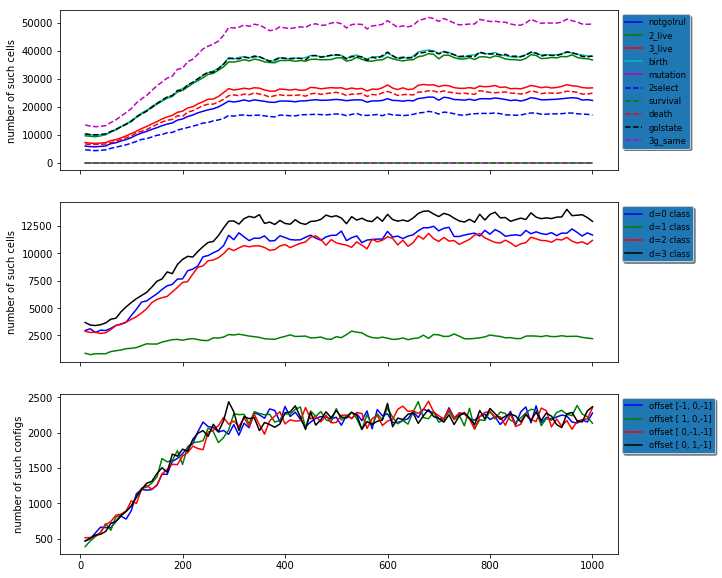

In [28]:
%matplotlib inline
# fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [10, 10]
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False)
ax1.plot(tpts,stepstats10[0][1:nt],'b',label='notgolrul')
ax1.plot(tpts,stepstats10[1][1:nt],'g',label='2_live')
ax1.plot(tpts,stepstats10[2][1:nt],'r',label='3_live')
ax1.plot(tpts,stepstats10[3][1:nt],'c',label='birth')
ax1.plot(tpts,stepstats10[4][1:nt],'m',label='mutation')
ax1.plot(tpts,stepstats10[5][1:nt],'b--',label='2select')
ax1.plot(tpts,stepstats10[6][1:nt],'g--',label='survival')
ax1.plot(tpts,stepstats10[7][1:nt],'r--',label='death')
ax1.plot(tpts,stepstats10[8][1:nt],'k--',label='golstate')
ax1.plot(tpts,stepstats10[9][1:nt],'m--',label='3g_same')
ax2.plot(tpts,genotypes4[0][1:nt],'b',label='d=0 class')
ax2.plot(tpts,genotypes4[1][1:nt],'g',label='d=1 class')
ax2.plot(tpts,genotypes4[2][1:nt],'r',label='d=2 class')
ax2.plot(tpts,genotypes4[3][1:nt],'k',label='d=3 class')
ax3.plot(tpts,configstats4[0][1:nt],'b',label='offset [-1, 0,-1]')
ax3.plot(tpts,configstats4[1][1:nt],'g',label='offset [ 1, 0,-1]')
ax3.plot(tpts,configstats4[2][1:nt],'r',label='offset [ 0,-1,-1]')
ax3.plot(tpts,configstats4[3][1:nt],'k',label='offset [ 0, 1,-1]')
ax1.set_ylabel('number of such cells')
ax2.set_ylabel('number of such cells')
ax3.set_ylabel('number of such configs')
legend1 = ax1.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')  # or use  loc = 'best'
legend2 = ax2.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')
legend3 = ax3.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')
legend1.get_frame().set_facecolor('C0')
legend2.get_frame().set_facecolor('C0')
legend3.get_frame().set_facecolor('C0')
plt.show()

## Space-time of one row

In [29]:
genelife.get_curgol(gol)
cnt = range(N)
for i in range(N):
    cnt[i] = sum([gol[(i*N)+j] for j in range(N)])

In [30]:
foo = [(i,cnt[i]) for i in range(N) if cnt[i] == max(cnt)]
foo

[(483, 117.0)]

In [31]:
myrow = foo[0][0]
for i in range(N):
    genelife.get_curgol(gol)
    for j in range(N):
        if gol[(N*myrow)+j]==1:
            cgrid[i][j] = 1
        else:
            cgrid[i][j] = 0
    genelife.genelife_update(1,0,0)
    

In [32]:
%matplotlib inline

Number of labels: 257


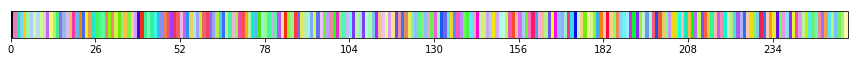

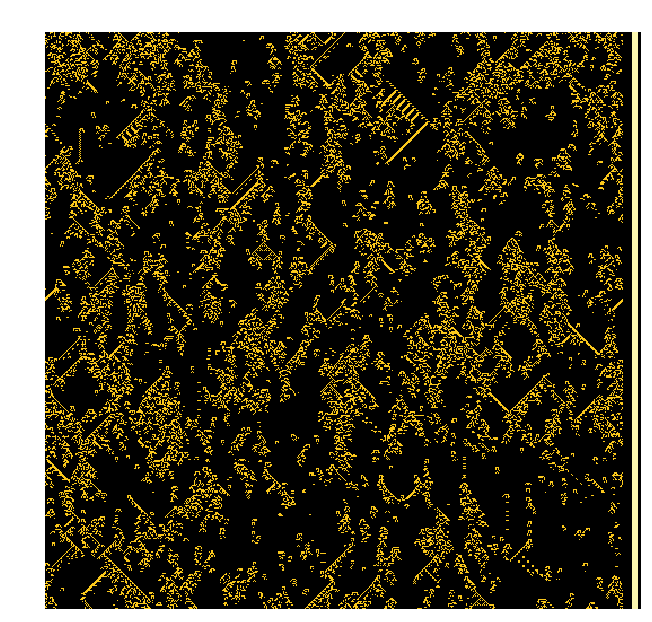

In [33]:
my_dpi=96
my_cmap = rand_cmap(257, type='bright', first_color_black=True, last_color_black=False)

fig, ax = plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
ax.axis('off')
# mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
mat = ax.matshow(cgrid, cmap=my_cmap, vmin = 0, vmax = 56)
plt.show()

# Gallery of example simulations
use ctrl-return to execute cell and stay on same cell

## Selection 0  Numerical value of gene determines fitness

In [ ]:
# 0
#  selection=0 gene value
#  Note that sequences must differ for replication unless it is forced.
#   
nrun=1; ndisp=1000; nskip=0; niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 10                                # set to n to turn on histogram configurations every nth step
nstat = 10                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # if 0, gene dynamics consistent with GoL still possible
repscheme = runparams[1] = 0x3           # bits 0 to 13 code for binary options, 14-20 code for quadrant pairs,21-24 for allowed canonical 2-live nb configs 
                                         # value 0x11 is simply game of life provided survivalmask is 3
selection = runparams[2] = 0             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
survivalmask = runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
birthmask = 1                            # birth mask for two (bit 1) and three (bit 0) live neighbours : GoL = 1
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs

colorfunction = runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # bits0-7 no of bits used to encode individual gene functions
                                         # bits8-15 no of bits to encode masks for add2ndmask1st functions
                                         # bits 16-23 number of planes used in selection modesl 10-12 
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run()

## Selection 1 Number of 1s in gene determines fitness

In [ ]:
# 1
#  selection=1 number of ones determines fitness
#  Note that sequences must differ in number of ones for replication unless it is forced.
#  ncoding plays no role, system takes about 4-5000 steps to reach all ones sequence
#  Color scheme: color gradient with colors going from black (no 1s) to white (all 1s)
nrun=1; ndisp=1000; nskip=0; niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x3           # bit 0,1 on allow selection in 3,2 live nb configs
selection = runparams[2] = 1             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0              # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run()

## Selection 2 Not well-ordered (tournament) selection - scissors-stone-well-paper model

In [ ]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
nrun=1; ndisp=1000; nskip=0; niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 10                                # set to n to turn on histogram configurations every nth step
nstat = 10                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x3           # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 2             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 8192    # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # not used in selection==2
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run()

## Selection 3 Cyclic not well-ordered selection for 4 species

In [ ]:
# 3
#  selection=3 scissors-stone-well-paper but only next color wins
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
nrun=1; ndisp=1000; nskip=0; niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 3               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x2ab         # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 3             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # not used in selection==2
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run()

## Selection 4 Cooperative birth requiring two individuals with different gene functions

In [ ]:
# 4
#  selection=4 cooperative birth between near-0 and near-1 sequences with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : overwritemask 3
#  For random start the ncoding value must be large, 28 or so.
#  Color scheme: green near 0, read near 1, white neither. Near means within ncoding bits. 
nrun=1; ndisp=200; nskip=0; niter=100;   # simulation time stepping parameters : set nskip=800 for faster long time
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x03          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 4             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 12              # no of bits away from targets and each other allowed for match
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run()

## Selection 5 Predator-prey model

In [ ]:
# 5
#  selection=5 with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : enforce birth with repscheme bits 3,4
#  Predator and prey must be within ncoding bits of one another
nrun=1; ndisp=200; nskip=800; niter=100; # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x33          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 5             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 8               # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run()

## Selection 6 Constrained selection involving two targets and distance constraint

In [ ]:
# 6
#  selection=6 with appropriate parameters for survival
#  in this model there are two target gene centres at all 0 sequence and the sequence with ncoding leading 1s
#  birth occurs if the two sequences have different distances to each target and these are less than their mutual distance
# the sequence which is closer to its target in selected as the ancestor for birth
# the initial asymmetry was corrected by disallowing equal distances to the targets (a biassed choice was made)
# one can enforce birth using repscheme, in which case the canonical rotation is used to maintain symmetry
nrun=1; ndisp=200; nskip=0; niter=1;       # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 0               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 7             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
selection = runparams[2] = 6             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3]= 0x0        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0x3        # selection 10,11: survival bit 0 determines if current plane used as well for nbs
colorfunction = runparams[5] = 0         # color function 0-8
initfield = runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # number of bits coding for functions
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
run()

## Selection 7 Neutral but different

In [ ]:
# 7
#  selection=7 with appropriate parameters for survival
#  in this version selection is neutral, but fails if the sequences are the same
nrun=1; ndisp=200; nskip=0; niter=1;       # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 3             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
selection = runparams[2] = 7             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3]= 0x0        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0x3        # selection 10,11: survival bit 0 determines if current plane used as well for nbs
colorfunction = runparams[5] = 0         # color function 0-8
initfield = runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # number of bits coding for functions
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
run()

## Selection 8 Totalistic LUT encoded by gene

In [ ]:
#  8 
#  selection=8 LUT with appropriate parameters for survival
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth is determined by the and of the live neighbour genes (bits 8-15 for ncoding=1) ie genecode
#  survival is determined the and of the live neighbour genes (bits 0-8 for ncoding=1) ie genecode
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
nrun=1; ndisp=100; nskip=0; niter=1;     # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
                                         # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
                                         # bits 9-12 plus bit 5, chose only 1 of 4 canonical 2nb configs for birth
                                         # for selection 9 (lut) repscheme only can be 0 (most difft) or 2 (first bit)
selection = runparams[2] = 8             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
                                         # for selection=9 this is the birth mask
survivalmask = runparams[4] = 0x406      # selection 10,11: survival bit 0 determines if current plane used as well for nbs
                                         #                  survival bit 1 determines if gol state 1 survives as in gol
                                         # selection<8: survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
                                         # for selection=8 this is the birth and survival mask
                                         # for selection=9 32-bit survival mask
colorfunction = runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                         # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
initfield = runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                         # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                         # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
run()

## Selection 9 Canonical rotation LUT encoded by gene

In [ ]:
# 9
#  selection=9 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation masks for s=0-8. Only 32 cases s=2-6 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example allows only one of the 4 canonical rotations for s=2 to be gene activated for birth, otherwise <=GoL
nrun=1; ndisp=100; nskip=0; niter=1;       # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
                                         # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
                                         # bits 9-12 plus bit 5, chose only 1 of 4 canonical 2nb configs for birth
                                         # for selection 9 (lut) repscheme only can be 0 (most difft) or 2 (first bit)
selection = runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3]= 0x000007f8 # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
                                         # for selection=9 this is the birth mask
survivalmask = runparams[4] = 0x000007ff # selection 10,11: survival bit 0 determines if current plane used as well for nbs
                                         #                  survival bit 1 determines if gol state 1 survives as in gol
                                         # selection<8: survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
                                         # for selection=8 this is the birth and survival mask
                                         # for selection=9 32-bit survival mask
colorfunction = runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                         # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
initfield = runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                         # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                         # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
run()

## Selection 10 GoL planes (2-16) coupled pairwise as specified by genes

In [ ]:
# 10
#  selection=10 with appropriate parameters for survival
#  this model involves gene encoded coupling between up to 16 parallel planes of game of life : packed into 64-bit word
#  the coupling makes bits on at most one other plane visible to first plane : locally dept on gene
nrun=1; ndisp=100; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0x1b          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
selection = runparams[2] = 10            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 color combined gol states, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 32768   # initial density of random genes
ncoding = simparams[3] = 0x100004        # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 16      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run()

## Selection 11 GoL planes (2-16) each coupled to 2 or 4 nearby planes as specified by genes

In [ ]:
# 11
# up to 16 parallel planes of GoL with coupling with genetically encoded subset of up to 4 nearest planes
# in this case all 16 planes used repscheme 0
nrun=1; ndisp=100; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0x1b          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
selection = runparams[2] = 11            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0(hash), ≥1(fnal), 2 color gol planes, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 6             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0x100000        # 16 planes also achieved with value 0
startgenechoice = simparams[4] = 16      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
run()

## Selection 12 64-plane GoL with simple coupling

In [ ]:
# 12
# 64 copies of game of life computed in overlay and in parallel
# for rulemod=0 uncoupeld copies of gol : need to set density of 
# first attempts to explore this model with coupling lead to over-proliferation
# even when coupling only two specific planes specified by the genes
# genes however are not yet proliferating : ie fixed and stationary
nrun=1; ndisp=1000; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x11          # bit 0 0: pure 3D 1: gene coupled 2D-3D 
                                         # bit 1 : only use birth not survival from 2D GoL 
                                         # [bit 2 used for canonical bit decision as in other models]
                                         # bit 4,5,6 specify subsets for 3D survival 56,67,6 instead of 567  
selection = runparams[2] = 12            # selects this case with 64 planes
overwritemask = runparams[3] = 0         # not used
survivalmask = runparams[4] = 0          # not used
colorfunction = runparams[5] = 2         # color function 0(hash), ≥1(fnal), 2 color gol planes, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation) : not yet used
initial1density = simparams[1] =  4096   # initial 1 density in GOL state (in 3D initial density should be between 4096 and 8192 not 16384)
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 32768   # initial density of random genes
ncoding = simparams[3] = 0x400400        # no of bit planes used is 64, ncoding 2 is 16 bits for genes
startgenechoice = simparams[4] = 16      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0(False)
# step(None) # no counts printed
run(True)

## Selection 13 Coupling of two planes of GoL by gene specified matching between configurations

In [ ]:
# 13
nrun=1; ndisp=100; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
                                         # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
                                         # bits 9-12 zusammen mit bit 5, chose only 1 of 4 canonical 2nb configs for birth
selection = runparams[2] = 13            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 3          # selection 10,11: survival bit 0 determines if current plane used as well for nbs
                                         #                  survival bit 1 determines if gol state 1 survives as in gol
                                         # selection<10: survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                         # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 9             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 32768   # initial density of random genes
ncoding = simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                         # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0(True)
# step()
run(True)